In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob
import cv2



In [2]:
# Function to remove the background from an image using thresholding
def remove_background(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # Apply a binary threshold to the grayscale image
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Create a 3-channel mask for the RGB image
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    # Apply the mask to the original image
    bg_removed = cv2.bitwise_and(np.array(image), mask_rgb)

    return Image.fromarray(bg_removed)



In [3]:
pokemons = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pokemon image classification/pokemon.csv")

selected_types = ['Water', 'Normal', 'Grass', 'Bug', 'Fire', 'Psychic', 'Electric']

pokemons['Type_Classified'] = pokemons['Type1'].apply(lambda x: x if x in selected_types else 'Other')

print(pokemons['Type_Classified'].value_counts())



Type_Classified
Other       294
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Electric     40
Name: count, dtype: int64


In [4]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/pokemon image classification/images/"
images = []

for pokemon in pokemons["Name"]:
    image_pattern = glob.glob(image_dir + pokemon + ".*")
    if image_pattern:
        image_path = image_pattern[0]
        image = Image.open(image_path).convert("RGB")


        image = remove_background(image)


        image = image.resize((120, 120))


        image_array = np.asarray(image)
        images.append(image_array)

    else:
        print(f"No image found for Pokémon: {pokemon}")


pokemons["Image"] = images



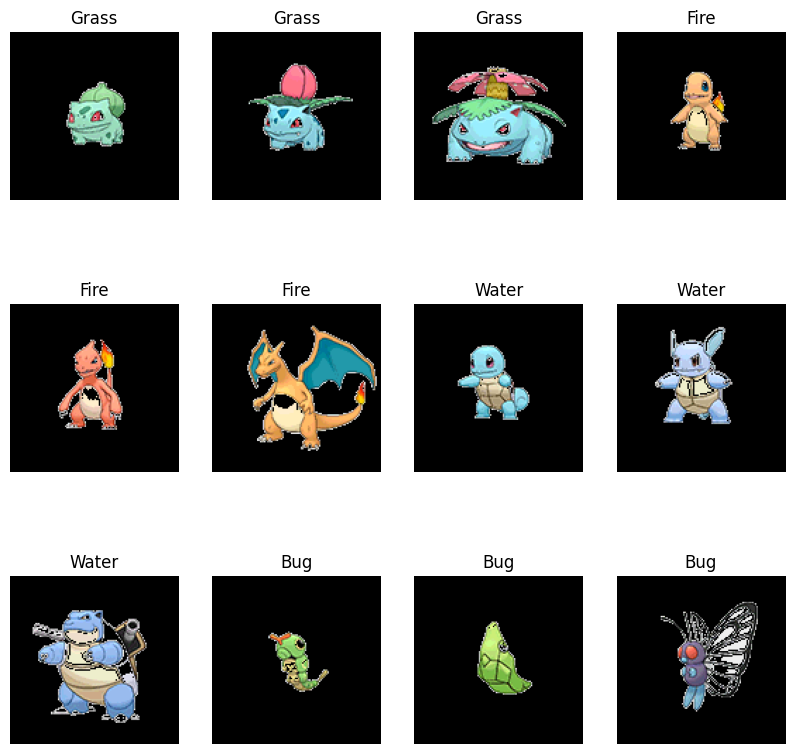

In [5]:
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.imshow(images[i].reshape(120, 120, 3))
    plt.title(pokemons["Type_Classified"].values[i])



In [6]:

le = LabelEncoder()
X = np.array(pokemons['Image'].tolist()) / 255.0
y = le.fit_transform(pokemons["Type_Classified"])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=1)


nb_classes = len(le.classes_)

y_train = y_train.flatten()
y_test = y_test.flatten()


In [7]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [8]:
from tensorflow.keras.layers import Flatten

model = Sequential()
model.add(Flatten(input_shape=(120, 120, 3)))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation="softmax"))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

training = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                     validation_data=(X_test, y_test),
                     epochs=50,
                     verbose=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.1832 - loss: 3.3204 - val_accuracy: 0.3370 - val_loss: 2.1449
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.1650 - loss: 2.9376 - val_accuracy: 0.3370 - val_loss: 1.9808
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - accuracy: 0.1775 - loss: 2.2051 - val_accuracy: 0.3741 - val_loss: 1.9460
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 388ms/step - accuracy: 0.2754 - loss: 2.0068 - val_accuracy: 0.2963 - val_loss: 1.9998
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 480ms/step - accuracy: 0.2864 - loss: 1.9960 - val_accuracy: 0.3481 - val_loss: 1.9336
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - accuracy: 0.2792 - loss: 1.9508 - val_accuracy: 0.3741 - val_loss: 1.8896
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 356ms/step - accuracy: 0.3178 - loss: 1.9069 - val_accuracy: 0.3741 - val_loss: 1.8647
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 462ms/step - accuracy: 0.3102 - loss: 1.9509 - val_accuracy: 0.3741 - v

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")



Test Accuracy: 38.15%
Test Loss: 1.7842


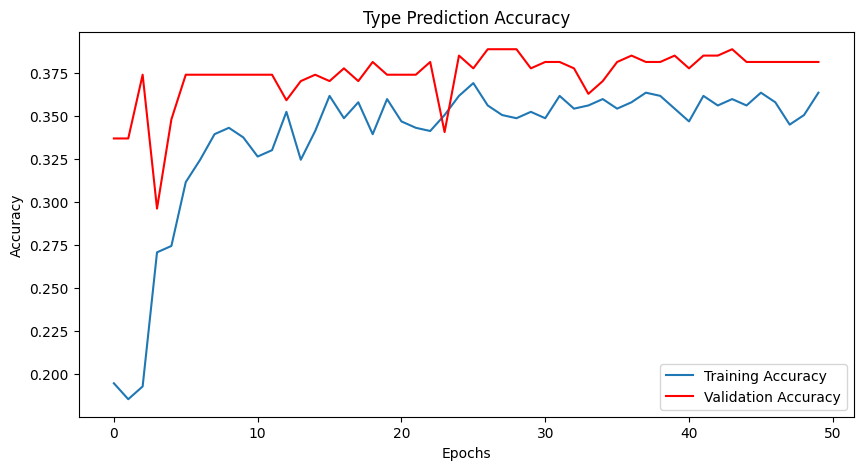

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(training.history["accuracy"], label="Training Accuracy")
plt.plot(training.history["val_accuracy"], "r", label="Validation Accuracy")
plt.legend()
plt.title("Type Prediction Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()



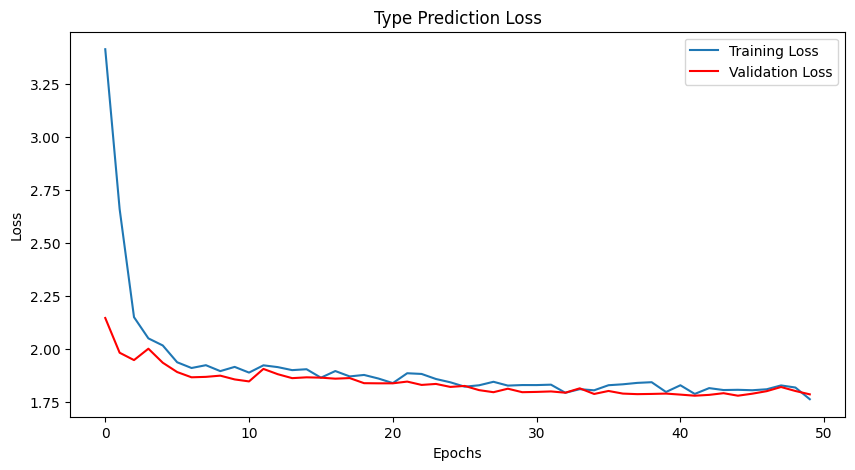

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(training.history["loss"], label="Training Loss")
plt.plot(training.history["val_loss"], "r", label="Validation Loss")
plt.legend()
plt.title("Type Prediction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()



In [14]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Classification Report:
              precision    recall  f1-score   support

         Bug       0.00      0.00      0.00        17
    Electric       0.00      0.00      0.00        13
        Fire       0.00      0.00      0.00        17
       Grass       0.00      0.00      0.00        27
      Normal       0.00      0.00      0.00        35
       Other       0.38      0.96      0.54       101
     Psychic       0.00      0.00      0.00        25
       Water       0.50      0.17      0.26        35

    accuracy                           0.38       270
   macro avg       0.11      0.14      0.10       270
weighted avg       0.21      0.38      0.24       270



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = remove_background(image)
    image = image.resize((120, 120))
    image_array = np.asarray(image) / 255.0
    return np.expand_dims(image_array, axis=0)



In [16]:
def predict_pokemon_type(image_path):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = le.inverse_transform(predicted_class)
    return predicted_label[0]



In [19]:
new_image_path = "/content/drive/MyDrive/data set/bulbasaur.png"
predicted_type = predict_pokemon_type(new_image_path)
print(f"The predicted Pokémon type is: {predicted_type}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
The predicted Pokémon type is: Water
